In [5]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
words=open('names.txt','r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [7]:
len(words)


32033

In [8]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [9]:
#build the dataset
block_size=3
X,Y=[],[]
for w in words:
    # print(w)
    context=[0]*block_size
    for ch in w+'.':
        ix=stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '->', itos[ix])
        context=context[1:]+[ix]

X=torch.tensor(X)   
Y=torch.tensor(Y)

In [10]:
X.shape,X.dtype,Y.shape,Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [11]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [12]:
C=torch.randn((27,2))

In [13]:
C[5]

tensor([0.2475, 0.0172])

In [14]:
emb=C[X]
emb.shape


torch.Size([228146, 3, 2])

In [15]:
W1=torch.randn((6,100))
b1=torch.randn(100)

In [16]:
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape#Not generalised

torch.Size([228146, 6])

In [17]:
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([228146, 6])

In [18]:
emb.shape

torch.Size([228146, 3, 2])

In [19]:
emb.view(32,6).shape #More efficient way than unbinding

RuntimeError: shape '[32, 6]' is invalid for input of size 1368876

In [ ]:
emb.view(-1,6) @ W1 + b1 #Making the dimension -1 because we don't want to hard code so we let the system figure it out

tensor([[ 3.8052,  3.5440,  0.2373,  ...,  3.9930, -1.9584,  2.2337],
        [ 3.6081,  1.6203,  1.3276,  ...,  4.9392, -2.1710,  2.2806],
        [ 6.0310,  2.9409, -0.8453,  ...,  5.5059, -3.1580,  0.4761],
        ...,
        [ 0.2463,  0.9519,  1.1649,  ...,  2.8706,  0.9380, -1.5670],
        [-1.6134, -1.9653,  0.0309,  ..., -2.2860, -2.1010, -2.3245],
        [ 0.8607,  1.0628, -0.6807,  ..., -0.7728,  0.3044, -2.0552]])

In [20]:
h=torch.tanh(emb.view(-1,6) @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [21]:
W2=torch.randn((100,27))
b2=torch.randn(27)

In [22]:
logits=h @ W2 + b2

In [23]:
logits.shape

torch.Size([228146, 27])

In [24]:
counts=logits.exp()

In [25]:
prob=counts/counts.sum(1,keepdim=True)

In [26]:
prob.shape

torch.Size([228146, 27])

In [27]:
loss = -prob[torch.arange(32),Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [28]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [29]:
#______Combining everything into a single cell______
Xtr.shape,Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [30]:
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((27,10),generator=g)
W1=torch.randn((30,200),generator=g)
b1=torch.randn(200,generator=g)
W2=torch.randn((200,27),generator=g)
b2=torch.randn(27,generator=g)  
parameters=[C,W1,b1,W2,b2]

In [31]:
sum(p.nelement() for p in parameters) #Total number of parameters

11897

In [32]:
# emb=C[X]
# h=torch.tanh(emb.view(-1,6) @ W1 + b1)
# logits=h @ W2 + b2
# # counts=logits.exp()
# # probs=counts/counts.sum(1,keepdim=True)
# # loss = -probs[torch.arange(32),Y].log().mean()
# loss=F.cross_entropy(logits,Y) #Using PyTorch's built-in function for cross entropy
# loss

# FOR (6,100) only

In [33]:
for p in parameters:
    p.requires_grad=True

In [34]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [35]:
lri = []
lossi = []
stepi = []

In [ ]:
for i in range(1):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.01 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

22.818544387817383


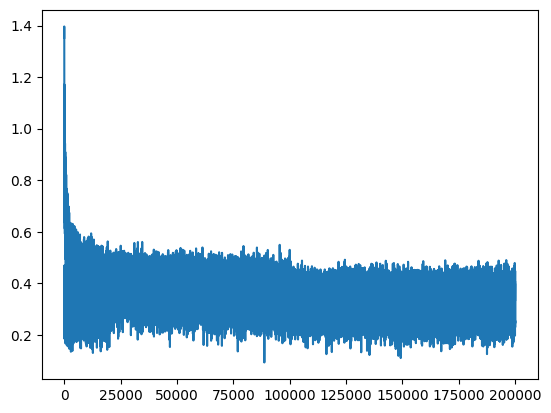

In [153]:
plt.plot(stepi, lossi)

In [154]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1238, grad_fn=<NllLossBackward0>)

In [155]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1711, grad_fn=<NllLossBackward0>)

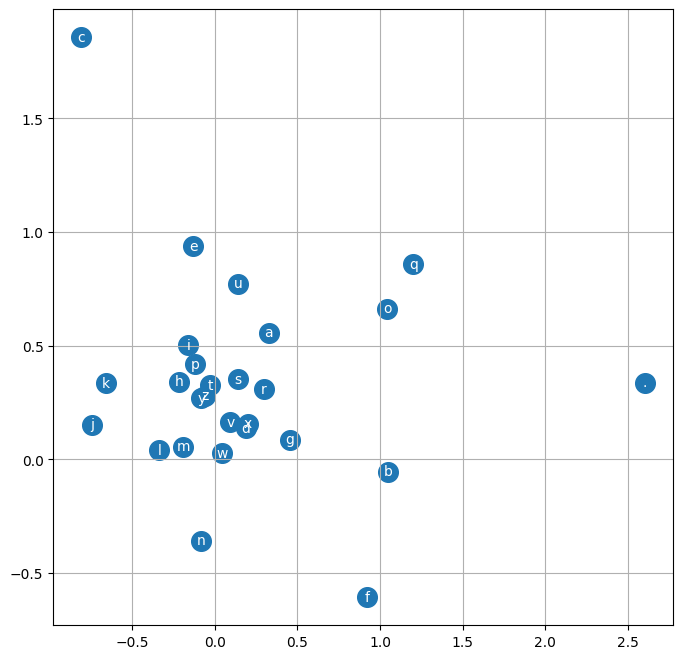

In [156]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [157]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [158]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khi.
mri.
reh.
cassanden.
jazonte.
deliah.
jaree.
correnia.
chaiir.
kaleigh.
ham.
join.
quint.
sulin.
alian.
quin.
elo.
dearysia.


In [2]:
# for _ in range(10000):
#     #Minibatch
#     ix=torch.randint(0,X.shape[0],(32,))
#     #Forward pass
#     emb=C[X[ix]]
#     h=torch.tanh(emb.view(-1,6) @ W1 + b1)
#     logits=h @ W2 + b2
#     loss=F.cross_entropy(logits,Y[ix])
#     # print(loss.item())
#     #Backward pass
#     for p in parameters:
#         p.grad=None
#     loss.backward()
#     #Update
#     for p in parameters:
#         p.data+=-0.01*p.grad

# print(loss.item())

In [3]:
# #Creating minni batches

# torch.randint(0,X.shape[0],(32,))

In [4]:
# emb=C[X[ix]]
# h=torch.tanh(emb.view(-1,6) @ W1 + b1)
# logits=h @ W2 + b2
# loss=F.cross_entropy(logits,Y[ix])
# loss

In [ ]:
#We need to split the data into train ,test,validation
#80,

# if the train and test losses are approximately same then we need more neural nets